# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

---


# DQN Banana Navigation Project

## 1. Import Packages

We begin by importing some necessary packages. If the code cell below returns an error, please revisit the project instructions to double-check that you have installed Unity ML-Agents and NumPy.


In [1]:
from unityagents import UnityEnvironment
import os
import sys
import argparse
import logging
import matplotlib
import numpy as np
import pandas as pd
import random
import time
import torch
from collections import deque
import matplotlib.pyplot as plt
import utils
from utils import Params
from utils import set_logger

from dqn_agent import Agent

###### %matplotlib inline


## 2. Initialize Unity Banana Environment

The simulation contains a single agent that navigates a large environment. At each time step, it has four actions at its disposal:

0 - walk forward
1 - walk backward
2 - turn left
3 - turn right
The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction. A reward of  +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana.

Run the code cell below to print some information about the environment.

In [2]:
# Initialize Unity Banana Environment
  
env_path = "C:\\Data\\AI\\DRL\\deep-reinforcement-learning\\p1_navigation\\Banana_Windows_x86_64\\"

env = UnityEnvironment(file_name=env_path + "Banana.exe")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 3. Define Main Deep Q-Network

This function will run or train the agent. If the agent will reach average score of 13.0 over 100 consecutive episodes it will save the learned weights to the xxx-model.pth file. You can read this weights while initializing new agent to run trained agent


In [3]:
# Define Main Deep Q-Network

def dqn(experiment_name, agent, params, train_mode=True):
    '''Deep Q-Learning.
    
    Params
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train (bool): flag deciding if the agent will train or just play through the episode
    '''
    list_params(params, "data/" + experiment_name + "/params.json")

    start_time = time.time()
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=params.mean_windowsize)  # last 100 scores
    eps = params.eps_start                    # initialize epsilon
    n_episodes = params.train_episodes if train_mode == True else params.test_episodes
    max_t = params.max_train_t if train_mode == True else params.max_test_t

    for i_episode in range(1, params.train_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        state = env_info.vector_observations[0]
        last_state = state
        score = 0
        looping = 0
        for t in range(max_t):
            
            if train_mode == True:
                action = agent.act(state, 1.0 if looping > 3 else eps)  # if looping take a random action
            else:
                action = agent.act(state, 0.0)
                
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
    
            if train_mode == True:
                agent.step(state, action, reward, next_state, done)

            if (next_state == last_state).all():
                looping += 1 
            else:
                looping = 0

            score += reward                                # update the score
            last_state = state
            state = next_state                             # roll over the state to next time step
            if done or looping > 5:                        # exit loop if episode finished
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(params.eps_end, params.eps_decay*eps) # decrease epsilon
        # print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)),end="")
        if i_episode % 100 == 0:
            end_time = time.time()
            logging.info('\rEpisode {}\tAverage Score: {:.2f}\tElapse time: {:.2f}'.format(i_episode, np.mean(scores_window), end_time - start_time))

        if np.mean(scores_window)>=params.target_score:
            end_time = time.time()
            logging.info('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}\tElapse time: {:.2f}'.format(i_episode, np.mean(scores_window),end_time - start_time))
            checkpoint = {
                'state_size': state_size,
                'action_size': action_size,
                'hidden_layers': [each.out_features for each in agent.qnetwork_local.hidden_layers],
                'state_dict': agent.qnetwork_local.state_dict(),
                'scores': scores}
            if train_mode == True:
                mode = 'Train'
            else:
                mode = 'Test'
            torch.save(checkpoint, "data/" + experiment_name + '/checkpoint-' + mode + '.pth')
            
            if train_mode == True:
                # Save trained neural network weights
                torch.save(agent.qnetwork_local.state_dict(), experiment_name + '-model.pth')
            # Save the recorded Scores 
            timestr = time.strftime("%Y%m%d-%H%M%S")
            scores_filename = experiment_name + '/Scores-' + mode + "_" + timestr + ".csv"
            np.savetxt("data/" + scores_filename, scores, delimiter=",")

            break

    return scores


## 4. Define Graph Functions

In [4]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot_scores(scores, filepath, smooth_window=50):
    scores_smoothed = moving_average(scores, smooth_window)
    # plot the scores
    timestr = time.strftime("%Y%m%d-%H%M%S")
    filename = filepath + "moving_average_" + timestr + ".png"
    logging.info(filename)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    plt.title = filename
    plt.plot(np.arange(len(scores)), scores, linewidth=1, alpha=0.4, color='steelblue')
    plt.plot(np.arange(len(scores))[smooth_window-1:,], scores_smoothed, linewidth=1.5, alpha=1, color='firebrick')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

    fig.savefig(filename)


    return fig
    
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    return (checkpoint['state_size'], checkpoint['action_size'], 
            checkpoint['hidden_layers'], 
            checkpoint['state_dict'], checkpoint['scores'])



## 5. Define Processing Functions


In [5]:
# Define Processing Functions

def list_params(params, json_path):

    logging.info("\rUsing hyperparameters from {}".format(json_path))
    for keys,values in params.__dict__.items():
        logging.info('\r\t {}\t: {}'.format(keys, values))
        
def train_model(experiment_name, env, params):
    
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state = env_info.vector_observations[0]
    state_size = len(state)

    agent = Agent(state_size=state_size, action_size=action_size, hidden_layers=[64, 64], seed=0, params=params)

    scores = dqn(experiment_name, agent, params=params)
    
    # plot moving average of training
    _, _, hidden_layers, state_dict, scores_train = load_checkpoint("data/" + experiment_name + '/checkpoint-Train.pth')
    figure = plot_scores(scores_train, "media/" + experiment_name + '_Train_')

    return scores

def test_model(experiment_name, env, params):
    
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=False)[brain_name]
    action_size = brain.vector_action_space_size
    state = env_info.vector_observations[0]
    state_size = len(state)

    agentT = Agent(state_size=state_size, action_size=action_size, hidden_layers=[64, 64], seed=0, params=params)
    # Load trained model weights
    agentT.qnetwork_local.load_state_dict(torch.load(experiment_name + "-model" + ".pth"))

    scores = dqn(experiment_name, agentT, params=params, train_mode=False)


    return scores


def run_model(experiment_name, train_mode):

    if experiment_name == None:
        experiment_name = input("enter experiment name (eg dqn-vanilla):")
        if experiment_name == "":
            experiment_name = "dqn-vanilla"
            
    if experiment_name == None:
        train_mode = input("Train/Eval:")
        if train_mode == "":
            train_mode = "Train,Eval"

    params = Params("data/" + experiment_name + "/params.json")
    set_logger(experiment_name + ".log")
    
    if "Train" in train_mode:
        # Train the agent
        scores = train_model(experiment_name, env, params)

    if "Eval" in train_mode:
        # Test 'Trained' Agent
        scores = test_model(experiment_name, env, params)

    return scores



## Main() - run experiments

Using hyperparameters from data/dqn-vanilla/params.json
	 experiment_name	: dqn-vanilla
	 model_type	: DQN
	 buffer_size	: 100000.0
	 gamma	: 0.99
	 alpha	: 0.0
	 beta_start	: 1.0
	 beta_increments	: 1
	 update_rate	: 4
	 target_tau	: 0.001
	 learning_rate	: 0.001
	 batch_size	: 32
	 dropout	: 0.0
	 eps_start	: 1.0
	 eps_end	: 0.01
	 eps_decay	: 0.97
	 max_train_t	: 300
	 max_test_t	: 300
	 mean_windowsize	: 100
	 target_score	: 13.0
	 train_episodes	: 1800
	 test_episodes	: 100
Episode 100	Average Score: 3.07	Elapse time: 183.86
Episode 200	Average Score: 6.58	Elapse time: 406.42
Episode 300	Average Score: 11.23	Elapse time: 693.57
Episode 400	Average Score: 11.69	Elapse time: 1039.03
INFO:root:
Environment solved in 449 episodes!	Average Score: 13.02	Elapse time: 1224.63
INFO:root:media/dqn-vanilla_Train_moving_average_20190207-072033.png


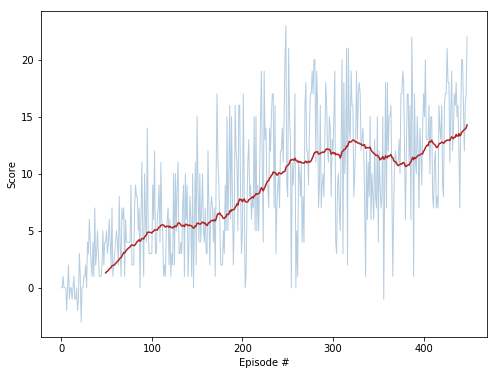

In [6]:
scores1 = run_model("dqn-vanilla", "Train")


In [7]:
run_model("dqn-vanilla", "Eval")

Using hyperparameters from data/dqn-vanilla/params.json
	 experiment_name	: dqn-vanilla
	 model_type	: DQN
	 buffer_size	: 100000.0
	 gamma	: 0.99
	 alpha	: 0.0
	 beta_start	: 1.0
	 beta_increments	: 1
	 update_rate	: 4
	 target_tau	: 0.001
	 learning_rate	: 0.001
	 batch_size	: 32
	 dropout	: 0.0
	 eps_start	: 1.0
	 eps_end	: 0.01
	 eps_decay	: 0.97
	 max_train_t	: 300
	 max_test_t	: 300
	 mean_windowsize	: 100
	 target_score	: 13.0
	 train_episodes	: 1800
	 test_episodes	: 100
INFO:root:
Environment solved in 1 episodes!	Average Score: 15.00	Elapse time: 29.96


[15.0]

Using hyperparameters from data/double-dqn/params.json
	 experiment_name	: double-dqn
	 model_type	: DDQN
	 buffer_size	: 100000.0
	 gamma	: 0.99
	 alpha	: 0.0
	 beta_start	: 1.0
	 beta_increments	: 1
	 update_rate	: 4
	 target_tau	: 0.001
	 learning_rate	: 0.001
	 batch_size	: 32
	 dropout	: 0.0
	 eps_start	: 1.0
	 eps_end	: 0.01
	 eps_decay	: 0.975
	 max_train_t	: 300
	 max_test_t	: 300
	 mean_windowsize	: 100
	 target_score	: 13.0
	 train_episodes	: 1800
	 test_episodes	: 100
Episode 100	Average Score: 3.26	Elapse time: 177.82
Episode 200	Average Score: 9.87	Elapse time: 425.23
Episode 300	Average Score: 11.81	Elapse time: 728.17
INFO:root:
Environment solved in 331 episodes!	Average Score: 13.03	Elapse time: 839.12
INFO:root:media/double-dqn_Train_moving_average_20190207-073502.png


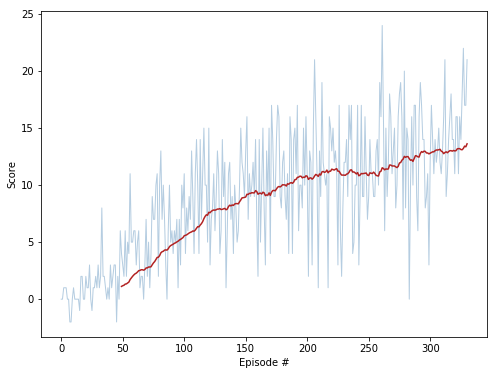

In [8]:
scores2 = run_model("double-dqn", "Train")

In [9]:
run_model("double-dqn", "Eval")

Using hyperparameters from data/double-dqn/params.json
	 experiment_name	: double-dqn
	 model_type	: DDQN
	 buffer_size	: 100000.0
	 gamma	: 0.99
	 alpha	: 0.0
	 beta_start	: 1.0
	 beta_increments	: 1
	 update_rate	: 4
	 target_tau	: 0.001
	 learning_rate	: 0.001
	 batch_size	: 32
	 dropout	: 0.0
	 eps_start	: 1.0
	 eps_end	: 0.01
	 eps_decay	: 0.975
	 max_train_t	: 300
	 max_test_t	: 300
	 mean_windowsize	: 100
	 target_score	: 13.0
	 train_episodes	: 1800
	 test_episodes	: 100
INFO:root:
Environment solved in 1 episodes!	Average Score: 16.00	Elapse time: 29.88


[16.0]

Using hyperparameters from data/ddqn-dropout/params.json
	 experiment_name	: ddqn-dropout
	 model_type	: DDQN
	 buffer_size	: 100000.0
	 gamma	: 0.99
	 alpha	: 0.0
	 beta_start	: 1.0
	 beta_increments	: 1
	 update_rate	: 1
	 target_tau	: 0.001
	 learning_rate	: 0.001
	 batch_size	: 32
	 dropout	: 0.2
	 eps_start	: 1.0
	 eps_end	: 0.01
	 eps_decay	: 0.975
	 max_train_t	: 300
	 max_test_t	: 300
	 mean_windowsize	: 100
	 target_score	: 13.0
	 train_episodes	: 1800
	 test_episodes	: 100
Episode 100	Average Score: 3.21	Elapse time: 364.11
Episode 200	Average Score: 11.46	Elapse time: 779.56
INFO:root:
Environment solved in 267 episodes!	Average Score: 13.02	Elapse time: 1104.77
INFO:root:media/ddqn-dropout_Train_moving_average_20190207-075357.png


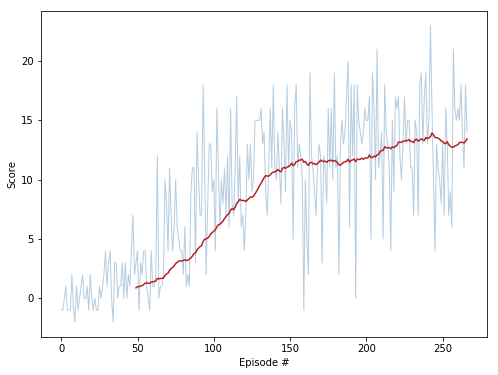

In [10]:
scores3 = run_model("ddqn-dropout", "Train")

In [11]:
run_model("ddqn-dropout", "Eval")

Using hyperparameters from data/ddqn-dropout/params.json
	 experiment_name	: ddqn-dropout
	 model_type	: DDQN
	 buffer_size	: 100000.0
	 gamma	: 0.99
	 alpha	: 0.0
	 beta_start	: 1.0
	 beta_increments	: 1
	 update_rate	: 1
	 target_tau	: 0.001
	 learning_rate	: 0.001
	 batch_size	: 32
	 dropout	: 0.2
	 eps_start	: 1.0
	 eps_end	: 0.01
	 eps_decay	: 0.975
	 max_train_t	: 300
	 max_test_t	: 300
	 mean_windowsize	: 100
	 target_score	: 13.0
	 train_episodes	: 1800
	 test_episodes	: 100
INFO:root:
Environment solved in 10 episodes!	Average Score: 13.00	Elapse time: 236.62


[6.0, 17.0, 7.0, 13.0, 20.0, 14.0, 9.0, 17.0, 8.0, 19.0]

Using hyperparameters from data/per-ddqn/params.json
	 experiment_name	: per-ddqn
	 model_type	: PERDDQN
	 buffer_size	: 100000.0
	 gamma	: 0.99
	 alpha	: 0.4
	 beta_start	: 0.4
	 beta_increments	: 200
	 update_rate	: 1
	 target_tau	: 0.001
	 learning_rate	: 0.001
	 batch_size	: 32
	 dropout	: 0.2
	 eps_start	: 1.0
	 eps_end	: 0.01
	 eps_decay	: 0.975
	 max_train_t	: 300
	 max_test_t	: 300
	 mean_windowsize	: 100
	 target_score	: 13.0
	 train_episodes	: 1800
	 test_episodes	: 100
Episode 100	Average Score: 1.88	Elapse time: 515.11
Episode 200	Average Score: 9.68	Elapse time: 1393.73
Episode 300	Average Score: 12.30	Elapse time: 2761.15
INFO:root:
Environment solved in 317 episodes!	Average Score: 13.00	Elapse time: 3051.98
INFO:root:media/per-ddqn_Train_moving_average_20190207-084846.png


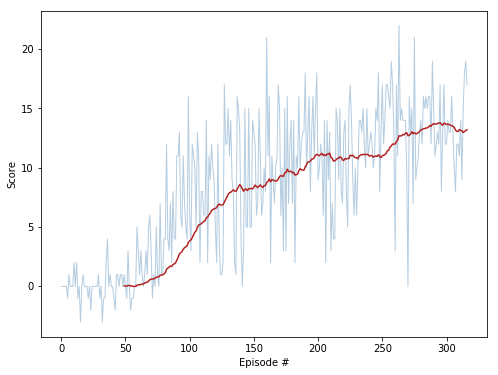

In [12]:
scores4 = run_model("per-ddqn", "Train")

In [13]:
run_model("per-ddqn", "Eval")

Using hyperparameters from data/per-ddqn/params.json
	 experiment_name	: per-ddqn
	 model_type	: PERDDQN
	 buffer_size	: 100000.0
	 gamma	: 0.99
	 alpha	: 0.4
	 beta_start	: 0.4
	 beta_increments	: 200
	 update_rate	: 1
	 target_tau	: 0.001
	 learning_rate	: 0.001
	 batch_size	: 32
	 dropout	: 0.2
	 eps_start	: 1.0
	 eps_end	: 0.01
	 eps_decay	: 0.975
	 max_train_t	: 300
	 max_test_t	: 300
	 mean_windowsize	: 100
	 target_score	: 13.0
	 train_episodes	: 1800
	 test_episodes	: 100
INFO:root:
Environment solved in 1 episodes!	Average Score: 14.00	Elapse time: 78.18


[14.0]

In [ ]:
env.close()